In [19]:
!pip install git+https://github.com/keras-team/keras-tuner.git -q
!pip install autokeras -q

In [20]:
from kerastuner.engine.oracle import Oracle
from kerastuner.engine import trial as trial_lib
import numpy as np
import tensorflow as tf
import autokeras as ak

SEED = 42
np.random.seed=SEED
tf.random.set_seed(SEED)

class RandomSearchOracle(Oracle):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # Add any new attributes.

    def _populate_space(self, trial_id):
        """Fill the hyperparameter space with values for a trial.
        This method should be overridden in subclasses and called in
        `create_trial` in order to populate the hyperparameter space with
        values.
        Args:
          `trial_id`: The id for this Trial.
        Returns:
            A dictionary with keys "values" and "status", where "values" is
            a mapping of parameter names to suggested values, and "status"
            is the TrialStatus that should be returned for this trial (one
            of "RUNNING", "IDLE", or "STOPPED").
        """
        values = self._random_values()
        if values is None:
            return {'status': trial_lib.TrialStatus.STOPPED,
                    'values': None}
        return {'status': trial_lib.TrialStatus.RUNNING,
                'values': values}

    def update_trial(self, trial_id, metrics, step=0):
        """Used by a worker to report the status of a trial.
        Args:
            trial_id: A previously seen trial id.
            metrics: Dict of float. The current value of this
                trial's metrics.
            step: (Optional) Float. Used to report intermediate results. The
                current value in a timeseries representing the state of the
                trial. This is the value that `metrics` will be associated with.
        Returns:
            Trial object. Trial.status will be set to "STOPPED" if the Trial
            should be stopped early.
        """
        super().update_trial(trial_id, metrics, step)

In [21]:
from kerastuner.engine.multi_execution_tuner import MultiExecutionTuner

class RandomSearch(MultiExecutionTuner):

    def __init__(self,
                 hypermodel,
                 objective,
                 max_trials,
                 seed=None,
                 hyperparameters=None,
                 tune_new_entries=True,
                 allow_new_entries=True,
                 **kwargs):
        self.seed = seed
        oracle = RandomSearchOracle(
            objective=objective,
            max_trials=max_trials,
            seed=seed,
            hyperparameters=hyperparameters,
            tune_new_entries=tune_new_entries,
            allow_new_entries=allow_new_entries)
        super(RandomSearch, self).__init__(
            oracle,
            hypermodel,
            **kwargs)

In [22]:
import pandas as pd
import tensorflow as tf

TRAIN_DATA_URL = "https://storage.googleapis.com/tf-datasets/titanic/train.csv"
TEST_DATA_URL = "https://storage.googleapis.com/tf-datasets/titanic/eval.csv"

train_file_path = tf.keras.utils.get_file("train.csv", TRAIN_DATA_URL)
test_file_path = tf.keras.utils.get_file("eval.csv", TEST_DATA_URL)

full_train_dataframe = pd.read_csv(train_file_path)
test_dataframe = pd.read_csv(test_file_path)

full_train_dataframe.head()

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,1,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,1,female,35.0,1,0,53.1000,First,C,Southampton,n
4,0,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [23]:
# Create training and validation datasets
val_dataframe = full_train_dataframe.sample(frac=0.2, random_state=1337)
train_dataframe = full_train_dataframe.drop(val_dataframe.index)

train_dataframe.to_numpy().astype(np.str)

array([['0', 'male', '22.0', ..., 'unknown', 'Southampton', 'n'],
       ['1', 'female', '38.0', ..., 'C', 'Cherbourg', 'n'],
       ['1', 'female', '26.0', ..., 'unknown', 'Southampton', 'y'],
       ...,
       ['0', 'male', '25.0', ..., 'unknown', 'Southampton', 'y'],
       ['1', 'female', '19.0', ..., 'B', 'Southampton', 'y'],
       ['0', 'female', '28.0', ..., 'unknown', 'Southampton', 'n']],
      dtype='<U11')

In [24]:
def dataframe_to_dataset(dataframe, train=True):
    dataframe = dataframe.copy()

    # Drop useless features
    dataframe.pop("embark_town")
    dataframe.pop("deck")
    
    if train:
        # Set aside labels
        labels = dataframe.pop("survived")
        # Create dataset
        ds = tf.data.Dataset.from_tensor_slices((dataframe.to_numpy().astype(np.str), labels))
        ds = ds.shuffle(buffer_size=len(dataframe))
    else:
        ds = tf.data.Dataset.from_tensor_slices(dataframe.to_numpy().astype(np.str))
    return ds

train_ds = dataframe_to_dataset(train_dataframe).batch(32).prefetch(32)
val_ds = dataframe_to_dataset(val_dataframe).batch(32).prefetch(32)
test_ds = dataframe_to_dataset(test_dataframe, train=False).batch(32).prefetch(32)
full_train_ds = dataframe_to_dataset(full_train_dataframe).batch(32).prefetch(32)

for data in train_ds:
    print(data)
    break

(<tf.Tensor: shape=(32, 7), dtype=string, numpy=
array([[b'female', b'26.0', b'1', b'1', b'26.0', b'Second', b'n'],
       [b'male', b'23.0', b'0', b'0', b'13.0', b'Second', b'y'],
       [b'male', b'18.0', b'1', b'1', b'20.2125', b'Third', b'n'],
       [b'female', b'0.75', b'2', b'1', b'19.2583', b'Third', b'n'],
       [b'male', b'50.0', b'1', b'0', b'55.9', b'First', b'n'],
       [b'female', b'22.0', b'0', b'1', b'55.0', b'First', b'n'],
       [b'female', b'23.0', b'0', b'0', b'7.925', b'Third', b'y'],
       [b'male', b'28.0', b'0', b'0', b'13.8625', b'Second', b'y'],
       [b'male', b'28.0', b'0', b'0', b'0.0', b'First', b'y'],
       [b'male', b'18.0', b'1', b'0', b'6.4958', b'Third', b'n'],
       [b'male', b'36.0', b'1', b'1', b'24.15', b'Third', b'n'],
       [b'male', b'25.0', b'1', b'0', b'17.8', b'Third', b'n'],
       [b'female', b'23.0', b'0', b'0', b'7.55', b'Third', b'y'],
       [b'male', b'52.0', b'0', b'0', b'30.5', b'First', b'y'],
       [b'male', b'25.0', b'0'

In [25]:
def build_model(hp):
    model = tf.keras.Sequential()
    encoding_layer = ak.MultiCategoryEncoding(encoding=['int', 'none', 'int', 'int', 'none', 'int', 'int'])
    encoding_layer.adapt(train_ds.map(lambda x, y: x))
    model.add(encoding_layer)
    model.add(tf.keras.layers.Dense(units=hp.Int('units',
                                        min_value=32,
                                        max_value=512,
                                        step=32),
                           activation='relu',
                           input_shape=(10,)))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Choice('learning_rate',
                      values=[1e-2, 1e-3, 1e-4])),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    return model

In [26]:
random_tuner = RandomSearch(
    build_model,
    overwrite=True,
    seed=SEED,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=3,
    directory='my_dir',
    project_name='helloworld')

In [27]:
random_tuner.search(train_ds, validation_data=val_ds, epochs=100)

Trial 10 Complete [00h 00m 31s]
val_accuracy: 0.8479999899864197

Best val_accuracy So Far: 0.8559999863306681
Total elapsed time: 00h 05m 01s
INFO:tensorflow:Oracle triggered exit


In [28]:
import matplotlib.pyplot as plt 

def plot_curve(x, y, xlabel, ylabel, title):
    plt.plot(x, y)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel) 
    plt.title(title)
    plt.show()

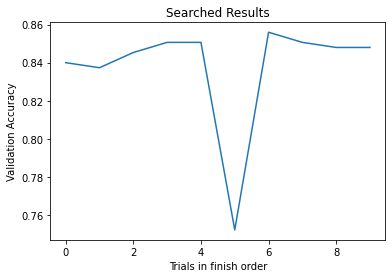

In [29]:
accuracy = [random_tuner.oracle.get_trial(trial_id).score for trial_id in random_tuner.oracle.end_order]
trial = list(range(len(accuracy)))
plot_curve(trial, accuracy, 'Trials in finish order', 'Validation Accuracy', 'Searched Results')

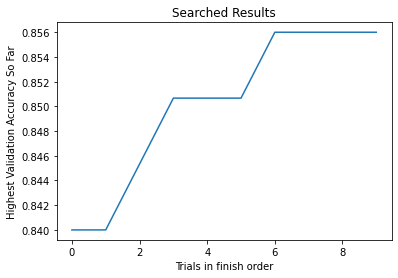

In [30]:
high_value = 0
high_acc = []
for value in accuracy:
  high_value = max(high_value, value)
  high_acc.append(high_value)
plot_curve(trial, high_acc, 'Trials in finish order', 'Highest Validation Accuracy So Far', 'Searched Results')

In [31]:
import random

import numpy as np
from scipy import optimize as scipy_optimize
from sklearn import exceptions
from sklearn import gaussian_process

from kerastuner.engine import hyperparameters as hp_module
from kerastuner.engine import multi_execution_tuner
from kerastuner.engine import oracle as oracle_module
from kerastuner.engine import trial as trial_lib


class BayesianOptimizationOracle(oracle_module.Oracle):
    """Bayesian optimization oracle.

    It uses Bayesian optimization with a underlying Gaussian process model.
    The acquisition function used is upper confidence bound (UCB), which can
    be found in the following link:
    https://www.cse.wustl.edu/~garnett/cse515t/spring_2015/files/lecture_notes/12.pdf

    # Arguments
        objective: String or `kerastuner.Objective`. If a string,
          the direction of the optimization (min or max) will be
          inferred.
        max_trials: Int. Total number of trials
            (model configurations) to test at most.
            Note that the oracle may interrupt the search
            before `max_trial` models have been tested if the search space has been
            exhausted.
        num_initial_points: (Optional) Int. The number of randomly generated samples
            as initial training data for Bayesian optimization. If not specified,
            a value of 3 times the dimensionality of the hyperparameter space is
            used.
        alpha: Float. Value added to the diagonal of the kernel matrix
            during fitting. It represents the expected amount of noise
            in the observed performances in Bayesian optimization.
        beta: Float. The balancing factor of exploration and exploitation.
            The larger it is, the more explorative it is.
        seed: Int. Random seed.
        hyperparameters: HyperParameters class instance.
            Can be used to override (or register in advance)
            hyperparamters in the search space.
        tune_new_entries: Whether hyperparameter entries
            that are requested by the hypermodel
            but that were not specified in `hyperparameters`
            should be added to the search space, or not.
            If not, then the default value for these parameters
            will be used.
        allow_new_entries: Whether the hypermodel is allowed
            to request hyperparameter entries not listed in
            `hyperparameters`.
    """

    def __init__(self,
                 objective,
                 max_trials,
                 num_initial_points=None,
                 alpha=1e-4,
                 beta=2.6,
                 seed=None,
                 hyperparameters=None,
                 allow_new_entries=True,
                 tune_new_entries=True):
        super(BayesianOptimizationOracle, self).__init__(
            objective=objective,
            max_trials=max_trials,
            hyperparameters=hyperparameters,
            tune_new_entries=tune_new_entries,
            allow_new_entries=allow_new_entries,
            seed=seed)
        self.num_initial_points = num_initial_points
        self.alpha = alpha
        self.beta = beta
        self.seed = seed or random.randint(1, 1e4)
        self._seed_state = self.seed
        self._tried_so_far = set()
        self._max_collisions = 20
        self._random_state = np.random.RandomState(self.seed)
        self.gpr = self._make_gpr()

    def _make_gpr(self):
        return gaussian_process.GaussianProcessRegressor(
            kernel=gaussian_process.kernels.Matern(nu=2.5),
            n_restarts_optimizer=20,
            normalize_y=True,
            alpha=self.alpha,
            random_state=self.seed)

    def _populate_space(self, trial_id):
        # Generate enough samples before training Gaussian process.
        completed_trials = [t for t in self.trials.values()
                            if t.status == 'COMPLETED']

        # Use 3 times the dimensionality of the space as the default number of
        # random points.
        dimensions = len(self.hyperparameters.space)
        num_initial_points = self.num_initial_points or 3 * dimensions
        if len(completed_trials) < num_initial_points:
            return self._random_populate_space()

        # Fit a GPR to the completed trials and return the predicted optimum values.
        x, y = self._vectorize_trials()
        try:
            self.gpr.fit(x, y)
        except exceptions.ConvergenceWarning:
            # If convergence of the GPR fails, create a random trial.
            return self._random_populate_space()
        except ValueError as e:
            if 'array must not contain infs or NaNs' in str(e):
                return self._random_populate_space()
            raise e

        def _upper_confidence_bound(x):
            x = x.reshape(1, -1)
            mu, sigma = self.gpr.predict(x, return_std=True)
            return mu - self.beta * sigma

        optimal_val = float('inf')
        optimal_x = None
        num_restarts = 50
        bounds = self._get_hp_bounds()
        x_seeds = self._random_state.uniform(bounds[:, 0], bounds[:, 1],
                                             size=(num_restarts, bounds.shape[0]))
        for x_try in x_seeds:
            # Sign of score is flipped when maximizing.
            result = scipy_optimize.minimize(_upper_confidence_bound,
                                             x0=x_try,
                                             bounds=bounds,
                                             method='L-BFGS-B')
            if result.fun[0] < optimal_val:
                optimal_val = result.fun[0]
                optimal_x = result.x

        values = self._vector_to_values(optimal_x)
        return {'status': trial_lib.TrialStatus.RUNNING,
                'values': values}

    def _random_populate_space(self):
        values = self._random_values()
        if values is None:
            return {'status': trial_lib.TrialStatus.STOPPED,
                    'values': None}
        return {'status': trial_lib.TrialStatus.RUNNING,
                'values': values}

    def get_state(self):
        state = super(BayesianOptimizationOracle, self).get_state()
        state.update({
            'num_initial_points': self.num_initial_points,
            'alpha': self.alpha,
            'beta': self.beta,
        })
        return state

    def set_state(self, state):
        super(BayesianOptimizationOracle, self).set_state(state)
        self.num_initial_points = state['num_initial_points']
        self.alpha = state['alpha']
        self.beta = state['beta']
        self.gpr = self._make_gpr()

    def _vectorize_trials(self):
        x = []
        y = []
        ongoing_trials = {t for t in self.ongoing_trials.values()}
        for trial in self.trials.values():
            # Create a vector representation of each Trial's hyperparameters.
            trial_hps = trial.hyperparameters
            vector = []
            for hp in self._nonfixed_space():
                # For hyperparameters not present in the trial (either added after
                # the trial or inactive in the trial), set to default value.
                if trial_hps.is_active(hp):
                    trial_value = trial_hps.values[hp.name]
                else:
                    trial_value = hp.default

                # Embed an HP value into the continuous space [0, 1].
                prob = hp_module.value_to_cumulative_prob(trial_value, hp)
                vector.append(prob)

            if trial in ongoing_trials:
                # "Hallucinate" the results of ongoing trials. This ensures that
                # repeat trials are not selected when running distributed.
                x_h = np.array(vector).reshape((1, -1))
                y_h_mean, y_h_std = self.gpr.predict(x_h, return_std=True)
                # Give a pessimistic estimate of the ongoing trial.
                score = y_h_mean[0] + y_h_std[0]
            elif trial.status == 'COMPLETED':
                score = trial.score
                # Always frame the optimization as a minimization for scipy.minimize.
                if self.objective.direction == 'max':
                    score = -1*score
            else:
                continue

            x.append(vector)
            y.append(score)

        x = np.array(x)
        y = np.array(y)
        return x, y

    def _vector_to_values(self, vector):
        hps = hp_module.HyperParameters()
        vector_index = 0
        for hp in self.hyperparameters.space:
            hps.merge([hp])
            if isinstance(hp, hp_module.Fixed):
                value = hp.value
            else:
                prob = vector[vector_index]
                vector_index += 1
                value = hp_module.cumulative_prob_to_value(prob, hp)

            if hps.is_active(hp):
                hps.values[hp.name] = value
        return hps.values

    def _find_closest(self, val, hp):
        values = [hp.min_value]
        while values[-1] + hp.step <= hp.max_value:
            values.append(values[-1] + hp.step)

        array = np.asarray(values)
        index = (np.abs(values - val)).argmin()
        return array[index]

    def _nonfixed_space(self):
        return [hp for hp in self.hyperparameters.space
                if not isinstance(hp, hp_module.Fixed)]

    def _get_hp_bounds(self):
        bounds = []
        for hp in self._nonfixed_space():
            bounds.append([0, 1])
        return np.array(bounds)


class BayesianOptimization(multi_execution_tuner.MultiExecutionTuner):
    """BayesianOptimization tuning with Gaussian process.

    # Arguments:
        hypermodel: Instance of HyperModel class
            (or callable that takes hyperparameters
            and returns a Model instance).
        objective: String. Name of model metric to minimize
            or maximize, e.g. "val_accuracy".
        max_trials: Int. Total number of trials
            (model configurations) to test at most.
            Note that the oracle may interrupt the search
            before `max_trial` models have been tested if the search space has
            been exhausted.
        num_initial_points: Int. The number of randomly generated samples as initial
            training data for Bayesian optimization.
        alpha: Float or array-like. Value added to the diagonal of
            the kernel matrix during fitting.
        beta: Float. The balancing factor of exploration and exploitation.
            The larger it is, the more explorative it is.
        seed: Int. Random seed.
        hyperparameters: HyperParameters class instance.
            Can be used to override (or register in advance)
            hyperparamters in the search space.
        tune_new_entries: Whether hyperparameter entries
            that are requested by the hypermodel
            but that were not specified in `hyperparameters`
            should be added to the search space, or not.
            If not, then the default value for these parameters
            will be used.
        allow_new_entries: Whether the hypermodel is allowed
            to request hyperparameter entries not listed in
            `hyperparameters`.
        **kwargs: Keyword arguments relevant to all `Tuner` subclasses.
            Please see the docstring for `Tuner`.
    """

    def __init__(self,
                 hypermodel,
                 objective,
                 max_trials,
                 num_initial_points=2,
                 alpha=1e-4,
                 beta=2.6,
                 seed=None,
                 hyperparameters=None,
                 tune_new_entries=True,
                 allow_new_entries=True,
                 **kwargs):
        oracle = BayesianOptimizationOracle(
            objective=objective,
            max_trials=max_trials,
            num_initial_points=num_initial_points,
            alpha=alpha,
            beta=beta,
            seed=seed,
            hyperparameters=hyperparameters,
            tune_new_entries=tune_new_entries,
            allow_new_entries=allow_new_entries)
        super(BayesianOptimization, self, ).__init__(oracle=oracle,
                                                     hypermodel=hypermodel,
                                                     **kwargs)

In [32]:
bayesian_tuner = BayesianOptimization(
    build_model,
    overwrite=True,
    seed=SEED,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=3,
    directory='my_dir',
    project_name='helloworld')

bayesian_tuner.search(train_ds, validation_data=val_ds, epochs=100)

Trial 10 Complete [00h 00m 28s]
val_accuracy: 0.6506666541099548

Best val_accuracy So Far: 0.8560000061988831
Total elapsed time: 00h 04m 53s
INFO:tensorflow:Oracle triggered exit


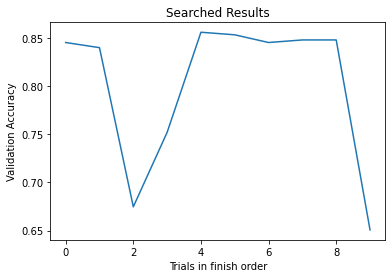

In [33]:
accuracy = [bayesian_tuner.oracle.get_trial(trial_id).score for trial_id in bayesian_tuner.oracle.end_order]
trial = list(range(len(accuracy)))
plot_curve(trial, accuracy, 'Trials in finish order', 'Validation Accuracy', 'Searched Results')

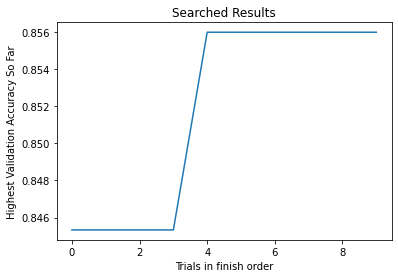

In [34]:
high_value = 0
high_acc = []
for value in accuracy:
  high_value = max(high_value, value)
  high_acc.append(high_value)
plot_curve(trial, high_acc, 'Trials in finish order', 'Highest Validation Accuracy So Far', 'Searched Results')